# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

MFCC tensors with repetitive padding


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs_reflection'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [12]:
from CNNMFCCs import CNNMFCCs

model = CNNMFCCs()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs(
  (conv1): Conv1d(40, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=22016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)

Visualize the model


In [13]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 172]           1,936
            Conv1d-2              [-1, 32, 172]           1,568
            Conv1d-3              [-1, 64, 172]           6,208
            Conv1d-4             [-1, 128, 172]          24,704
           Dropout-5             [-1, 128, 172]               0
            Linear-6                  [-1, 128]       2,818,176
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                    [-1, 9]             585
Total params: 2,861,433
Trainable params: 2,861,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 10.92
Estimated Total Size (MB): 11.43
-------------------------------------

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 100

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 39.69it/s, Loss=1.2266305685043335, Elapsed=2.0758s, ETA=0.0000s]

Epoch 1 completed in 10.9087s
Train Loss: 1.460596939387349 - Train Accuracy: 35.47861875579476
Validation Loss: 1.1994124603271485 - Validation Accuracy: 46.3064584212748

Epoch 2/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.83it/s, Loss=1.3985365629196167, Elapsed=1.2550s, ETA=0.0000s]


Epoch 2 completed in 6.2287s
Train Loss: 1.1519196284988713 - Train Accuracy: 48.06539879242894
Validation Loss: 1.1118051107724507 - Validation Accuracy: 48.016040523427606

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.36it/s, Loss=1.149781346321106, Elapsed=1.3309s, ETA=0.0000s] 


Epoch 3 completed in 6.3553s
Train Loss: 1.053418686107404 - Train Accuracy: 52.09741977793356
Validation Loss: 1.02443763256073 - Validation Accuracy: 54.51667370198396

Epoch 4/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.96it/s, Loss=1.1942188739776611, Elapsed=1.3340s, ETA=0.0000s]

Epoch 4 completed in 6.4077s
Train Loss: 0.990293772234393 - Train Accuracy: 54.84498315280071
Validation Loss: 1.0078287728627522 - Validation Accuracy: 52.02617138032926

Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.42it/s, Loss=1.3028321266174316, Elapsed=1.4092s, ETA=0.0000s]


Epoch 5 completed in 6.8244s
Train Loss: 0.944816636384567 - Train Accuracy: 57.09504534044911
Validation Loss: 0.981113318602244 - Validation Accuracy: 57.450401013085695

Epoch 6/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 70.08it/s, Loss=1.2676033973693848, Elapsed=1.2418s, ETA=0.0000s]

Epoch 6 completed in 6.5746s
Train Loss: 0.8943184503930153 - Train Accuracy: 58.88604961443657
Validation Loss: 0.9895411785443624 - Validation Accuracy: 56.76445757703672

Epoch 7/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.18it/s, Loss=1.3738479614257812, Elapsed=1.3401s, ETA=0.0000s]

Epoch 7 completed in 6.3747s
Train Loss: 0.8526248525332853 - Train Accuracy: 60.53006490129123
Validation Loss: 0.9655490032831828 - Validation Accuracy: 56.63782186576615

Epoch 8/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.99it/s, Loss=1.4288547039031982, Elapsed=1.2988s, ETA=0.0000s]


Epoch 8 completed in 6.3404s
Train Loss: 0.8050506805753432 - Train Accuracy: 62.38664887723028
Validation Loss: 0.9547485931714376 - Validation Accuracy: 59.91979738286197

Epoch 9/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.48it/s, Loss=1.1492167711257935, Elapsed=1.3125s, ETA=0.0000s]

Epoch 9 completed in 6.3806s
Train Loss: 0.7686988838835259 - Train Accuracy: 64.15730082992243
Validation Loss: 0.9526678156852723 - Validation Accuracy: 58.864499788940485

Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.79it/s, Loss=1.180185079574585, Elapsed=1.3132s, ETA=0.0000s] 


Epoch 10 completed in 6.3717s
Train Loss: 0.7320763105257398 - Train Accuracy: 65.49829266638024
Validation Loss: 0.9502877863248189 - Validation Accuracy: 61.02785985647953

Epoch 11/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 70.22it/s, Loss=1.0212141275405884, Elapsed=1.2722s, ETA=0.0000s]

Epoch 11 completed in 6.2645s
Train Loss: 0.690126585822574 - Train Accuracy: 67.12195563193958
Validation Loss: 0.9906797448794047 - Validation Accuracy: 59.93035035880118

Epoch 12/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.43it/s, Loss=1.0678611993789673, Elapsed=1.3782s, ETA=0.0000s]

Epoch 12 completed in 6.3406s
Train Loss: 0.6483887459845902 - Train Accuracy: 68.44259514710205
Validation Loss: 1.0156770730018616 - Validation Accuracy: 60.09919797382862

Epoch 13/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.95it/s, Loss=2.053401231765747, Elapsed=1.4080s, ETA=0.0000s] 


Epoch 13 completed in 6.4736s
Train Loss: 0.6074120187001422 - Train Accuracy: 70.45521358630515
Validation Loss: 1.0162548979123434 - Validation Accuracy: 61.03841283241874

Epoch 14/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 73.30it/s, Loss=1.65181565284729, Elapsed=1.2284s, ETA=0.0000s]  


Epoch 14 completed in 6.0426s
Train Loss: 0.568546279834185 - Train Accuracy: 71.80298952986138
Validation Loss: 1.0750425283114116 - Validation Accuracy: 61.07007176023639

Epoch 15/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.67it/s, Loss=1.9724925756454468, Elapsed=1.3658s, ETA=0.0000s]


Epoch 15 completed in 6.4402s
Train Loss: 0.5182692778937389 - Train Accuracy: 73.71384636258792
Validation Loss: 1.1758573420842489 - Validation Accuracy: 61.745462220346134

Epoch 16/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.22it/s, Loss=2.4007797241210938, Elapsed=1.3475s, ETA=0.0000s]

Epoch 16 completed in 6.4508s
Train Loss: 0.5047294823937334 - Train Accuracy: 74.32441600144728
Validation Loss: 1.2006561342875164 - Validation Accuracy: 61.122836639932466

Epoch 17/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.17it/s, Loss=1.8820093870162964, Elapsed=1.2990s, ETA=0.0000s]

Epoch 17 completed in 6.4137s
Train Loss: 0.4578625792368299 - Train Accuracy: 76.63327378394881
Validation Loss: 1.2674426023165386 - Validation Accuracy: 61.27057830308147

Epoch 18/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.03it/s, Loss=2.7733840942382812, Elapsed=1.3108s, ETA=0.0000s]

Epoch 18 completed in 6.2128s
Train Loss: 0.42576718537104613 - Train Accuracy: 78.07828859591596
Validation Loss: 1.26993355512619 - Validation Accuracy: 60.57408189109329

Epoch 19/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.02it/s, Loss=2.446544885635376, Elapsed=1.3108s, ETA=0.0000s] 

Epoch 19 completed in 6.5008s
Train Loss: 0.40877771136388613 - Train Accuracy: 78.81775626964564
Validation Loss: 1.3262589899698893 - Validation Accuracy: 61.523849725622625

Epoch 20/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.53it/s, Loss=2.8598732948303223, Elapsed=1.2901s, ETA=0.0000s]


Epoch 20 completed in 6.2908s
Train Loss: 0.37253221266531533 - Train Accuracy: 80.39166911648311
Validation Loss: 1.4103670732180278 - Validation Accuracy: 62.31532292106374

Epoch 21/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.00it/s, Loss=3.1589653491973877, Elapsed=1.3602s, ETA=0.0000s]

Epoch 21 completed in 6.2946s
Train Loss: 0.3592433385938578 - Train Accuracy: 81.35275095542842
Validation Loss: 1.4444570199648539 - Validation Accuracy: 61.154495567750104

Epoch 22/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.69it/s, Loss=1.9855605363845825, Elapsed=1.3012s, ETA=0.0000s]

Epoch 22 completed in 6.2564s
Train Loss: 0.3324328091620021 - Train Accuracy: 82.3500146988987
Validation Loss: 1.5699172353744506 - Validation Accuracy: 62.230899113550024

Epoch 23/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.27it/s, Loss=3.231114149093628, Elapsed=1.3415s, ETA=0.0000s] 

Epoch 23 completed in 6.2996s
Train Loss: 0.344598875827872 - Train Accuracy: 82.4404694602112
Validation Loss: 1.5655009444554646 - Validation Accuracy: 61.69269734065006

Epoch 24/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.01it/s, Loss=3.444805145263672, Elapsed=1.2532s, ETA=0.0000s] 

Epoch 24 completed in 6.4729s
Train Loss: 0.3055365300721171 - Train Accuracy: 83.89226837927681
Validation Loss: 1.7004332764943442 - Validation Accuracy: 61.72435626846771

Epoch 25/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 72.79it/s, Loss=4.4806809425354, Elapsed=1.2334s, ETA=0.0000s]   

Epoch 25 completed in 6.0886s
Train Loss: 0.27941652697462566 - Train Accuracy: 85.16315777571742
Validation Loss: 1.735906834602356 - Validation Accuracy: 62.01983959476573

Epoch 26/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.05it/s, Loss=4.4133620262146, Elapsed=1.3070s, ETA=0.0000s]   


Epoch 26 completed in 6.2283s
Train Loss: 0.25866140845107893 - Train Accuracy: 85.99081884172678
Validation Loss: 1.8174154798189799 - Validation Accuracy: 62.62135922330098

Epoch 27/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 71.36it/s, Loss=4.189632415771484, Elapsed=1.2292s, ETA=0.0000s] 

Epoch 27 completed in 6.1150s
Train Loss: 0.2490312979701971 - Train Accuracy: 86.8478777051627
Validation Loss: 1.8837578757603963 - Validation Accuracy: 61.988180666948075

Epoch 28/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.12it/s, Loss=4.145022869110107, Elapsed=1.3112s, ETA=0.0000s] 

Epoch 28 completed in 6.3547s
Train Loss: 0.260170679582509 - Train Accuracy: 86.54711562379865
Validation Loss: 1.7739049061139425 - Validation Accuracy: 61.523849725622625

Epoch 29/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.07it/s, Loss=3.674403190612793, Elapsed=1.3271s, ETA=0.0000s] 

Epoch 29 completed in 6.4976s
Train Loss: 0.22679917998827262 - Train Accuracy: 87.72755025892675
Validation Loss: 1.8732126092910766 - Validation Accuracy: 62.062051498522585

Epoch 30/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.00it/s, Loss=4.737969875335693, Elapsed=1.3265s, ETA=0.0000s] 

Epoch 30 completed in 6.2261s
Train Loss: 0.21665693772149225 - Train Accuracy: 88.7338594785283
Validation Loss: 2.0203501478830974 - Validation Accuracy: 62.50527648796961

Epoch 31/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.09it/s, Loss=5.215616226196289, Elapsed=1.3112s, ETA=0.0000s] 

Epoch 31 completed in 6.4538s
Train Loss: 0.20711852795299077 - Train Accuracy: 89.28563352253455
Validation Loss: 2.029673638343811 - Validation Accuracy: 61.33389615871676

Epoch 32/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.10it/s, Loss=3.6272077560424805, Elapsed=1.2639s, ETA=0.0000s]

Epoch 32 completed in 6.2709s
Train Loss: 0.2123897778505535 - Train Accuracy: 88.99843965536735
Validation Loss: 1.9745673767725627 - Validation Accuracy: 60.911777121148155

Epoch 33/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.69it/s, Loss=5.101343154907227, Elapsed=1.2644s, ETA=0.0000s] 

Epoch 33 completed in 6.7836s
Train Loss: 0.2115383563143325 - Train Accuracy: 89.25397435607518
Validation Loss: 2.0448699522018434 - Validation Accuracy: 61.23891937526382

Epoch 34/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.84it/s, Loss=4.7712225914001465, Elapsed=1.3398s, ETA=0.0000s]

Epoch 34 completed in 6.3409s
Train Loss: 0.18558258802301622 - Train Accuracy: 90.26254494470952
Validation Loss: 2.1451946973800657 - Validation Accuracy: 61.60827353313635

Epoch 35/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.51it/s, Loss=5.130300998687744, Elapsed=1.3422s, ETA=0.0000s] 

Epoch 35 completed in 6.3378s
Train Loss: 0.18234861026265028 - Train Accuracy: 90.61531851382827
Validation Loss: 2.147424209912618 - Validation Accuracy: 61.26002532714225

Epoch 36/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.97it/s, Loss=6.4420976638793945, Elapsed=1.2427s, ETA=0.0000s]

Epoch 36 completed in 6.3455s
Train Loss: 0.16472060254888038 - Train Accuracy: 91.46559327016575
Validation Loss: 2.2152714252471926 - Validation Accuracy: 60.7956943858168

Epoch 37/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.86it/s, Loss=5.636106014251709, Elapsed=1.3894s, ETA=0.0000s] 

Epoch 37 completed in 6.4973s
Train Loss: 0.16713853195481906 - Train Accuracy: 91.37061577078764
Validation Loss: 2.2366331911087034 - Validation Accuracy: 62.00928661882651

Epoch 38/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.98it/s, Loss=5.27949857711792, Elapsed=1.3697s, ETA=0.0000s]  

Epoch 38 completed in 6.3340s
Train Loss: 0.18080975933571083 - Train Accuracy: 90.96130797584858
Validation Loss: 2.2934676456451415 - Validation Accuracy: 60.521317011397215

Epoch 39/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.48it/s, Loss=6.2633538246154785, Elapsed=1.3150s, ETA=0.0000s]

Epoch 39 completed in 6.2046s
Train Loss: 0.1758088286578483 - Train Accuracy: 91.11734243911263
Validation Loss: 2.2478414964675903 - Validation Accuracy: 61.63993246095399

Epoch 40/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.90it/s, Loss=5.9289703369140625, Elapsed=1.3293s, ETA=0.0000s]

Epoch 40 completed in 6.2144s
Train Loss: 0.17608861937429865 - Train Accuracy: 91.18744487912981
Validation Loss: 2.0861375538508096 - Validation Accuracy: 61.154495567750104

Epoch 41/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.05it/s, Loss=4.852737903594971, Elapsed=1.3112s, ETA=0.0000s] 

Epoch 41 completed in 6.3173s
Train Loss: 0.1662199110051111 - Train Accuracy: 91.6171049953642
Validation Loss: 2.243528288205465 - Validation Accuracy: 61.2916842549599

Epoch 42/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.91it/s, Loss=8.235187530517578, Elapsed=1.4004s, ETA=0.0000s] 

Epoch 42 completed in 6.3992s
Train Loss: 0.14738295403863652 - Train Accuracy: 92.61889147690012
Validation Loss: 2.4197538153330487 - Validation Accuracy: 62.25200506542845

Epoch 43/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.68it/s, Loss=6.751028537750244, Elapsed=1.3453s, ETA=0.0000s] 

Epoch 43 completed in 6.3802s
Train Loss: 0.15014638608547648 - Train Accuracy: 92.57592546527668
Validation Loss: 2.336885552406311 - Validation Accuracy: 61.71380329252849

Epoch 44/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.19it/s, Loss=3.5622453689575195, Elapsed=1.3820s, ETA=0.0000s]

Epoch 44 completed in 6.3949s
Train Loss: 0.14825015032739308 - Train Accuracy: 92.53974356075167
Validation Loss: 2.3316968854268394 - Validation Accuracy: 61.72435626846771

Epoch 45/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.51it/s, Loss=4.134963035583496, Elapsed=1.2523s, ETA=0.0000s] 

Epoch 45 completed in 6.1639s
Train Loss: 0.13492005019088013 - Train Accuracy: 93.3425295674001
Validation Loss: 2.366092627843221 - Validation Accuracy: 61.76656817222457

Epoch 46/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.10it/s, Loss=4.577006816864014, Elapsed=1.3747s, ETA=0.0000s] 

Epoch 46 completed in 6.1278s
Train Loss: 0.1407576193333189 - Train Accuracy: 93.17292688993916
Validation Loss: 2.4117804606755575 - Validation Accuracy: 61.84043900379908

Epoch 47/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.56it/s, Loss=5.297430515289307, Elapsed=1.2550s, ETA=0.0000s] 

Epoch 47 completed in 6.4577s
Train Loss: 0.13142239680309173 - Train Accuracy: 93.6478143868298
Validation Loss: 2.5136232503255207 - Validation Accuracy: 61.682144364710844

Epoch 48/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.70it/s, Loss=8.28032398223877, Elapsed=1.3025s, ETA=0.0000s]  

Epoch 48 completed in 6.3231s
Train Loss: 0.14669234901020636 - Train Accuracy: 92.92643766536261
Validation Loss: 2.327850662867228 - Validation Accuracy: 61.756015196285354

Epoch 49/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.05it/s, Loss=5.029455184936523, Elapsed=1.3333s, ETA=0.0000s] 

Epoch 49 completed in 6.4398s
Train Loss: 0.12069200960154823 - Train Accuracy: 94.14531557404852
Validation Loss: 2.457218117713928 - Validation Accuracy: 61.682144364710844

Epoch 50/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.73it/s, Loss=3.610339641571045, Elapsed=1.2996s, ETA=0.0000s] 

Epoch 50 completed in 6.4529s
Train Loss: 0.13518000691267795 - Train Accuracy: 93.61163248230478
Validation Loss: 2.4439078172047934 - Validation Accuracy: 62.36808780075982

Epoch 51/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.83it/s, Loss=4.413168430328369, Elapsed=1.3076s, ETA=0.0000s] 

Epoch 51 completed in 6.3624s
Train Loss: 0.13485187969326629 - Train Accuracy: 93.48273444743448
Validation Loss: 2.4743412288029987 - Validation Accuracy: 62.08315745040102

Epoch 52/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.46it/s, Loss=6.079598903656006, Elapsed=1.3424s, ETA=0.0000s] 


Epoch 52 completed in 6.6206s
Train Loss: 0.11951679487664231 - Train Accuracy: 94.1588837882454
Validation Loss: 2.608357671101888 - Validation Accuracy: 62.38919375263824

Epoch 53/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 72.16it/s, Loss=4.375677108764648, Elapsed=1.2461s, ETA=0.0000s] 


Epoch 53 completed in 6.3258s
Train Loss: 0.12043166239180661 - Train Accuracy: 94.27421360891884
Validation Loss: 2.4448247241973875 - Validation Accuracy: 60.922330097087375

Epoch 54/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.80it/s, Loss=7.482761383056641, Elapsed=1.3771s, ETA=0.0000s] 

Epoch 54 completed in 6.3838s
Train Loss: 0.11284150693544073 - Train Accuracy: 94.54105515479071
Validation Loss: 2.5601774056752524 - Validation Accuracy: 61.54495567750106

Epoch 55/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.19it/s, Loss=4.468963623046875, Elapsed=1.3121s, ETA=0.0000s] 

Epoch 55 completed in 6.2828s
Train Loss: 0.12021086929161424 - Train Accuracy: 94.16340652631104
Validation Loss: 2.6214254506429038 - Validation Accuracy: 62.125369354157876

Epoch 56/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.18it/s, Loss=4.707133769989014, Elapsed=1.3350s, ETA=0.0000s] 

Epoch 56 completed in 6.4654s
Train Loss: 0.1145410119270572 - Train Accuracy: 94.5026118812329
Validation Loss: 2.531153127352397 - Validation Accuracy: 61.207260447446174

Epoch 57/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.80it/s, Loss=5.2767229080200195, Elapsed=1.2403s, ETA=0.0000s]

Epoch 57 completed in 6.3067s
Train Loss: 0.11531288509467089 - Train Accuracy: 94.48678229800322
Validation Loss: 2.596388308207194 - Validation Accuracy: 61.69269734065006

Epoch 58/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.93it/s, Loss=4.910547733306885, Elapsed=1.3145s, ETA=0.0000s] 

Epoch 58 completed in 6.4036s
Train Loss: 0.11455528064485575 - Train Accuracy: 94.74683973677665
Validation Loss: 2.6409122546513877 - Validation Accuracy: 61.344449134655974

Epoch 59/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.65it/s, Loss=6.865955829620361, Elapsed=1.3858s, ETA=0.0000s] 

Epoch 59 completed in 6.3007s
Train Loss: 0.11150284226703851 - Train Accuracy: 94.71065783225164
Validation Loss: 2.616223923365275 - Validation Accuracy: 62.20979316167159

Epoch 60/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.95it/s, Loss=5.298793315887451, Elapsed=1.3603s, ETA=0.0000s] 

Epoch 60 completed in 6.4235s
Train Loss: 0.10616761948805668 - Train Accuracy: 95.00237443748445
Validation Loss: 2.688673036893209 - Validation Accuracy: 62.167581257914726

Epoch 61/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.77it/s, Loss=4.905664920806885, Elapsed=1.3511s, ETA=0.0000s] 

Epoch 61 completed in 6.3562s
Train Loss: 0.1085147387105864 - Train Accuracy: 94.89382872390945
Validation Loss: 2.5759820985794066 - Validation Accuracy: 62.18868720979316

Epoch 62/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.97it/s, Loss=7.993870735168457, Elapsed=1.2564s, ETA=0.0000s] 


Epoch 62 completed in 6.0780s
Train Loss: 0.10249087841093885 - Train Accuracy: 95.2827841975532
Validation Loss: 2.718534657160441 - Validation Accuracy: 62.473617560151965

Epoch 63/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.96it/s, Loss=4.61835241317749, Elapsed=1.2738s, ETA=0.0000s]  

Epoch 63 completed in 6.1790s
Train Loss: 0.0935096283836258 - Train Accuracy: 95.51796657696569
Validation Loss: 2.654056879679362 - Validation Accuracy: 62.0726044744618

Epoch 64/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.08it/s, Loss=2.402488946914673, Elapsed=1.3420s, ETA=0.0000s] 

Epoch 64 completed in 6.7101s
Train Loss: 0.10921504075848901 - Train Accuracy: 94.94810158069696
Validation Loss: 2.58153134504954 - Validation Accuracy: 61.281131279020684

Epoch 65/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.14it/s, Loss=3.56547474861145, Elapsed=1.3844s, ETA=0.0000s]  

Epoch 65 completed in 6.4244s
Train Loss: 0.10693692238839893 - Train Accuracy: 94.9187037832704
Validation Loss: 2.7126738341649372 - Validation Accuracy: 62.33642887294217

Epoch 66/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.13it/s, Loss=2.465866804122925, Elapsed=1.3131s, ETA=0.0000s] 

Epoch 66 completed in 6.2782s
Train Loss: 0.0928982500029954 - Train Accuracy: 95.58128490988445
Validation Loss: 2.720181353886922 - Validation Accuracy: 62.5685943436049

Epoch 67/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.80it/s, Loss=3.211817979812622, Elapsed=1.3148s, ETA=0.0000s] 

Epoch 67 completed in 6.3089s
Train Loss: 0.09397766217212543 - Train Accuracy: 95.73279663508288
Validation Loss: 2.8762018569310506 - Validation Accuracy: 62.5685943436049

Epoch 68/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.60it/s, Loss=5.228116035461426, Elapsed=1.2661s, ETA=0.0000s] 

Epoch 68 completed in 6.2340s
Train Loss: 0.091687153857955 - Train Accuracy: 95.67852377829537
Validation Loss: 2.7688155460357664 - Validation Accuracy: 62.44195863233431

Epoch 69/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.60it/s, Loss=3.851097583770752, Elapsed=1.3826s, ETA=0.0000s] 

Epoch 69 completed in 6.3877s
Train Loss: 0.10533814019162875 - Train Accuracy: 95.04986318717351
Validation Loss: 2.57357172648112 - Validation Accuracy: 61.27057830308147

Epoch 70/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.09it/s, Loss=3.4169633388519287, Elapsed=1.3711s, ETA=0.0000s]

Epoch 70 completed in 6.3897s
Train Loss: 0.10452670559308605 - Train Accuracy: 95.12901110332194
Validation Loss: 2.702957229614258 - Validation Accuracy: 61.682144364710844

Epoch 71/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.07it/s, Loss=3.364795207977295, Elapsed=1.3094s, ETA=0.0000s] 

Epoch 71 completed in 6.2552s
Train Loss: 0.10141842940962212 - Train Accuracy: 95.42977318468601
Validation Loss: 2.6768071381251017 - Validation Accuracy: 62.37864077669902

Epoch 72/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.49it/s, Loss=3.406669855117798, Elapsed=1.4195s, ETA=0.0000s] 

Epoch 72 completed in 6.3287s
Train Loss: 0.09182174229789848 - Train Accuracy: 95.8820469912485
Validation Loss: 2.7564171346028647 - Validation Accuracy: 62.600253271422545

Epoch 73/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.17it/s, Loss=3.2817468643188477, Elapsed=1.3336s, ETA=0.0000s]

Epoch 73 completed in 6.5217s
Train Loss: 0.09858702479544058 - Train Accuracy: 95.54736437439225
Validation Loss: 2.6006159162521363 - Validation Accuracy: 62.01983959476573

Epoch 74/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.29it/s, Loss=3.792543649673462, Elapsed=1.2538s, ETA=0.0000s] 

Epoch 74 completed in 6.3236s
Train Loss: 0.0943146035064421 - Train Accuracy: 95.73505800411569
Validation Loss: 2.736055099169413 - Validation Accuracy: 62.31532292106374

Epoch 75/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.19it/s, Loss=3.163827419281006, Elapsed=1.3114s, ETA=0.0000s] 

Epoch 75 completed in 6.4087s
Train Loss: 0.0924490257677746 - Train Accuracy: 95.68756925442663
Validation Loss: 2.6737157917022705 - Validation Accuracy: 61.71380329252849

Epoch 76/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.32it/s, Loss=3.12699294090271, Elapsed=1.3051s, ETA=0.0000s]  

Epoch 76 completed in 6.2772s
Train Loss: 0.08636988841557089 - Train Accuracy: 96.23255919133443
Validation Loss: 2.8554533894856773 - Validation Accuracy: 61.745462220346134

Epoch 77/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.95it/s, Loss=3.4855875968933105, Elapsed=1.2564s, ETA=0.0000s]

Epoch 77 completed in 6.5842s
Train Loss: 0.08491178832657506 - Train Accuracy: 95.95214943126568
Validation Loss: 2.698349857330322 - Validation Accuracy: 61.84043900379908

Epoch 78/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.48it/s, Loss=3.7162024974823, Elapsed=1.3471s, ETA=0.0000s]   

Epoch 78 completed in 6.3143s
Train Loss: 0.09211430713168287 - Train Accuracy: 95.88430836028131
Validation Loss: 2.8175012334187826 - Validation Accuracy: 62.230899113550024

Epoch 79/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.67it/s, Loss=3.050989866256714, Elapsed=1.4032s, ETA=0.0000s] 

Epoch 79 completed in 7.3224s
Train Loss: 0.08437612455478208 - Train Accuracy: 96.11496800162818
Validation Loss: 2.7051886733373007 - Validation Accuracy: 62.51582946390882

Epoch 80/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.93it/s, Loss=1.943483829498291, Elapsed=1.2838s, ETA=0.0000s] 

Epoch 80 completed in 6.6261s
Train Loss: 0.08497847395416112 - Train Accuracy: 96.16245675131725
Validation Loss: 2.5755106449127196 - Validation Accuracy: 61.935415787252005

Epoch 81/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.64it/s, Loss=3.0092263221740723, Elapsed=1.2495s, ETA=0.0000s]

Epoch 81 completed in 6.7887s
Train Loss: 0.08325026869623131 - Train Accuracy: 96.27100246489223
Validation Loss: 2.753341112136841 - Validation Accuracy: 62.15702828197551

Epoch 82/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.66it/s, Loss=1.9619896411895752, Elapsed=1.3550s, ETA=0.0000s]

Epoch 82 completed in 6.7443s
Train Loss: 0.08960531520619558 - Train Accuracy: 96.13984306098912
Validation Loss: 2.675607509613037 - Validation Accuracy: 61.449978894048115

Epoch 83/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.06it/s, Loss=2.0394177436828613, Elapsed=1.3281s, ETA=0.0000s]

Epoch 83 completed in 7.2707s
Train Loss: 0.08632419415550426 - Train Accuracy: 96.1511499061532
Validation Loss: 2.5820656538009645 - Validation Accuracy: 62.38919375263824

Epoch 84/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.30it/s, Loss=4.029217720031738, Elapsed=1.2861s, ETA=0.0000s] 


Epoch 84 completed in 6.8728s
Train Loss: 0.08859433079235299 - Train Accuracy: 96.04260419257818
Validation Loss: 2.8285869344075523 - Validation Accuracy: 62.20979316167159

Epoch 85/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.36it/s, Loss=3.399420976638794, Elapsed=1.4065s, ETA=0.0000s] 

Epoch 85 completed in 7.4623s
Train Loss: 0.079823664701786 - Train Accuracy: 96.3004002623188
Validation Loss: 2.8201471249262493 - Validation Accuracy: 62.44195863233431

Epoch 86/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.94it/s, Loss=1.6534005403518677, Elapsed=1.3026s, ETA=0.0000s]

Epoch 86 completed in 6.8854s
Train Loss: 0.07039796158999764 - Train Accuracy: 96.88835621085005
Validation Loss: 2.8360053396224973 - Validation Accuracy: 61.95652173913043

Epoch 87/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.97it/s, Loss=3.657088041305542, Elapsed=1.2998s, ETA=0.0000s] 

Epoch 87 completed in 6.5996s
Train Loss: 0.0692597660989732 - Train Accuracy: 96.88157210375161
Validation Loss: 2.9371091254552204 - Validation Accuracy: 62.50527648796961

Epoch 88/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.34it/s, Loss=2.6015806198120117, Elapsed=1.4433s, ETA=0.0000s]


Epoch 88 completed in 6.8963s
Train Loss: 0.07839300207029275 - Train Accuracy: 96.46095746364848
Validation Loss: 2.6516585604349774 - Validation Accuracy: 62.90628957365977

Epoch 89/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 59.41it/s, Loss=1.7834227085113525, Elapsed=1.4731s, ETA=0.0000s]

Epoch 89 completed in 6.8730s
Train Loss: 0.08567748279068511 - Train Accuracy: 96.3524117500735
Validation Loss: 2.673135221799215 - Validation Accuracy: 61.53440270156184

Epoch 90/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.58it/s, Loss=0.9393980503082275, Elapsed=1.2431s, ETA=0.0000s]

Epoch 90 completed in 6.4202s
Train Loss: 0.10623961462601589 - Train Accuracy: 95.41394360145632
Validation Loss: 2.6790234438578286 - Validation Accuracy: 62.34698184888139

Epoch 91/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.70it/s, Loss=3.517855167388916, Elapsed=1.3222s, ETA=0.0000s] 

Epoch 91 completed in 6.7543s
Train Loss: 0.07677115792559319 - Train Accuracy: 96.62829877207662
Validation Loss: 2.6498630317052205 - Validation Accuracy: 62.758547910510764

Epoch 92/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.88it/s, Loss=2.871814250946045, Elapsed=1.4051s, ETA=0.0000s] 

Epoch 92 completed in 7.0048s
Train Loss: 0.0676373094024212 - Train Accuracy: 96.80242418760318
Validation Loss: 2.824896389643351 - Validation Accuracy: 62.20979316167159

Epoch 93/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.13it/s, Loss=3.563530206680298, Elapsed=1.2721s, ETA=0.0000s] 

Epoch 93 completed in 6.8161s
Train Loss: 0.0719476351299124 - Train Accuracy: 96.83860609212817
Validation Loss: 2.750351940790812 - Validation Accuracy: 61.31279020683833

Epoch 94/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.21it/s, Loss=3.831305742263794, Elapsed=1.3655s, ETA=0.0000s] 

Epoch 94 completed in 6.6981s
Train Loss: 0.08226641391355523 - Train Accuracy: 96.51523032043599
Validation Loss: 2.779242746035258 - Validation Accuracy: 61.47108484592655

Epoch 95/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 71.25it/s, Loss=3.517930030822754, Elapsed=1.2394s, ETA=0.0000s] 


Epoch 95 completed in 6.4761s
Train Loss: 0.07226463695288221 - Train Accuracy: 96.8250378779313
Validation Loss: 2.850540736516317 - Validation Accuracy: 63.212325875897

Epoch 96/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.06it/s, Loss=2.3953680992126465, Elapsed=1.3093s, ETA=0.0000s]

Epoch 96 completed in 6.5835s
Train Loss: 0.06496843900746865 - Train Accuracy: 97.08509531670472
Validation Loss: 2.8095454676946003 - Validation Accuracy: 62.51582946390882

Epoch 97/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.92it/s, Loss=3.406491756439209, Elapsed=1.3537s, ETA=0.0000s] 

Epoch 97 completed in 6.7619s
Train Loss: 0.07809428549021741 - Train Accuracy: 96.52879853463287
Validation Loss: 2.850373922983805 - Validation Accuracy: 62.62135922330098

Epoch 98/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.85it/s, Loss=5.180366039276123, Elapsed=1.3173s, ETA=0.0000s] 

Epoch 98 completed in 6.5834s
Train Loss: 0.06614414198227184 - Train Accuracy: 96.98333371022817
Validation Loss: 2.8244959751764935 - Validation Accuracy: 62.65301815111861

Epoch 99/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.56it/s, Loss=4.5349225997924805, Elapsed=1.2926s, ETA=0.0000s]

Epoch 99 completed in 6.7004s
Train Loss: 0.06510202549236445 - Train Accuracy: 97.11223174509848
Validation Loss: 2.8096456638971965 - Validation Accuracy: 62.821865766146054

Epoch 100/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.02it/s, Loss=3.9238812923431396, Elapsed=1.4747s, ETA=0.0000s]


Epoch 100 completed in 7.0831s
Train Loss: 0.0648451568397311 - Train Accuracy: 97.16424323285317
Validation Loss: 2.9700432062149047 - Validation Accuracy: 62.32587589700296



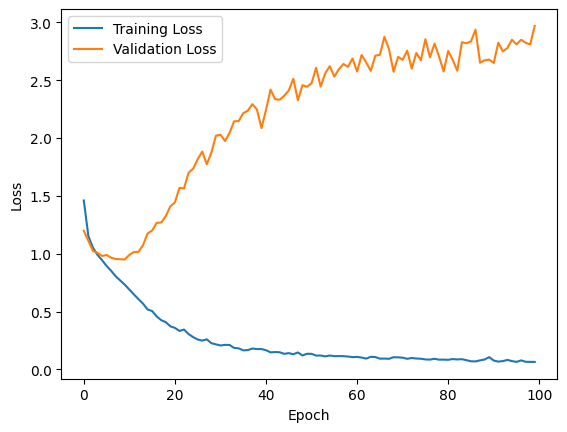

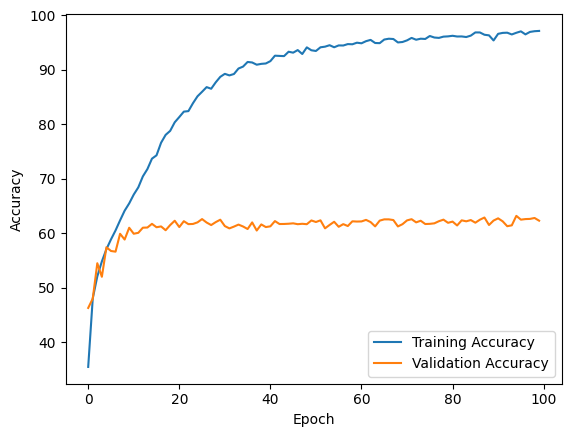

In [15]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:02<00:00, 34.46it/s]


Test Accuracy: 0.6196
Test Precision: 0.6199
Test Recall: 0.6196
Test F1-score: 0.6178

              precision    recall  f1-score   support

       Anger       0.63      0.67      0.65       916
       Bored       0.62      0.80      0.70      1098
     Disgust       0.46      0.49      0.47       291
        Fear       0.47      0.44      0.45       308
       Happy       0.59      0.53      0.56      1914
     Neutral       0.59      0.57      0.58      2226
    Question       0.75      0.70      0.72      1139
         Sad       0.65      0.62      0.64       857
    Surprise       0.66      0.66      0.66       728

    accuracy                           0.62      9477
   macro avg       0.60      0.61      0.60      9477
weighted avg       0.62      0.62      0.62      9477



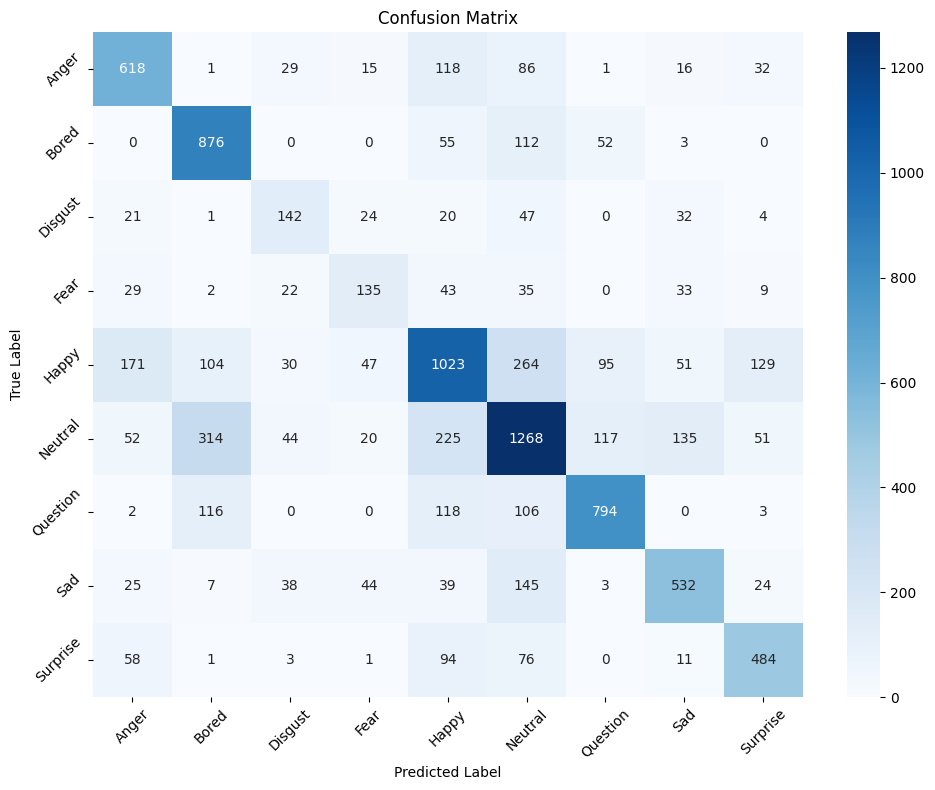

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)